Predictions: [100.  50.]


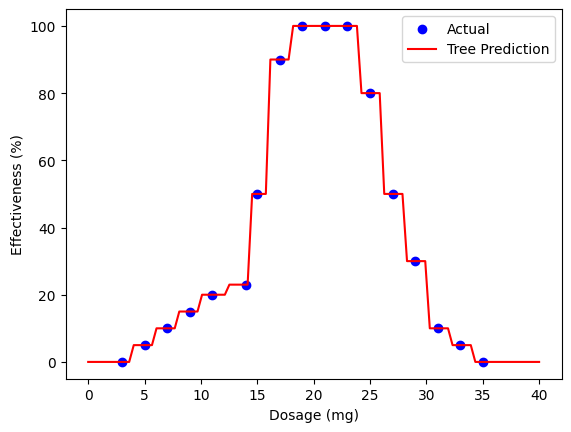

In [1]:
# Example 1: Basic Regression Tree
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Drug dosage data
dosage = np.array([3, 5, 7, 9, 11, 14, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]).reshape(-1, 1)
effectiveness = np.array([0, 5, 10, 15, 20, 23, 50, 90, 100, 100, 100, 80, 50, 30, 10, 5, 0])

# Create and fit the regression tree
tree = DecisionTreeRegressor(random_state=42)
tree.fit(dosage, effectiveness)

# Make predictions
test_dosage = np.array([20, 27]).reshape(-1, 1)
predictions = tree.predict(test_dosage)
print(f"Predictions: {predictions}")

# Visualize
dosage_range = np.linspace(0, 40, 100).reshape(-1, 1)
tree_predictions = tree.predict(dosage_range)

plt.scatter(dosage, effectiveness, color='blue', label='Actual')
plt.plot(dosage_range, tree_predictions, color='red', label='Tree Prediction')
plt.xlabel('Dosage (mg)')
plt.ylabel('Effectiveness (%)')
plt.legend()
plt.show()

In [2]:
# Example 2: Understanding Sum of Squared Residuals
import numpy as np

def calculate_ssr(y_actual, y_predicted):
    """Calculate sum of squared residuals"""
    residuals = y_actual - y_predicted
    ssr = np.sum(residuals ** 2)
    return ssr

# Sample data
dosage = np.array([3, 5, 7, 9, 11, 14])
effectiveness = np.array([0, 5, 10, 15, 20, 23])

# Try different thresholds and find best split
def find_best_split(X, y):
    best_ssr = float('inf')
    best_threshold = None
    
    # Get unique thresholds (midpoints between consecutive values)
    thresholds = []
    for i in range(len(X) - 1):
        thresholds.append((X[i] + X[i+1]) / 2)
    
    for threshold in thresholds:
        # Split data
        left_mask = X <= threshold
        right_mask = X > threshold
        
        # Calculate predictions (mean of each group)
        left_pred = np.mean(y[left_mask]) if np.any(left_mask) else 0
        right_pred = np.mean(y[right_mask]) if np.any(right_mask) else 0
        
        # Calculate SSR
        y_pred = np.where(left_mask, left_pred, right_pred)
        ssr = calculate_ssr(y, y_pred)
        
        print(f"Threshold: {threshold:.1f}, SSR: {ssr:.2f}")
        
        if ssr < best_ssr:
            best_ssr = ssr
            best_threshold = threshold
    
    print(f"\nBest threshold: {best_threshold:.1f} with SSR: {best_ssr:.2f}")
    return best_threshold, best_ssr

best_threshold, best_ssr = find_best_split(dosage, effectiveness)

Threshold: 4.0, SSR: 213.20
Threshold: 6.0, SSR: 110.50
Threshold: 8.0, SSR: 82.67
Threshold: 10.0, SSR: 129.50
Threshold: 12.5, SSR: 250.00

Best threshold: 8.0 with SSR: 82.67


In [3]:
# Example 3: Preventing Overfitting with min_samples_leaf
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate more realistic noisy data
np.random.seed(42)
dosage = np.linspace(0, 40, 100).reshape(-1, 1)
# True relationship with noise
effectiveness = 50 * np.sin(dosage.ravel() / 5) + 50 + np.random.normal(0, 10, 100)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    dosage, effectiveness, test_size=0.3, random_state=42
)

# Compare different min_samples_leaf values
min_samples_values = [1, 7, 20]

for min_samples in min_samples_values:
    tree = DecisionTreeRegressor(
        min_samples_leaf=min_samples,
        random_state=42
    )
    tree.fit(X_train, y_train)
    
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)
    
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    print(f"\nmin_samples_leaf={min_samples}:")
    print(f"  Training MSE: {train_mse:.2f}")
    print(f"  Test MSE: {test_mse:.2f}")
    print(f"  Number of leaves: {tree.get_n_leaves()}")
    
    # Low training error but high test error = overfitting!


min_samples_leaf=1:
  Training MSE: 0.00
  Test MSE: 169.01
  Number of leaves: 70

min_samples_leaf=7:
  Training MSE: 114.00
  Test MSE: 202.01
  Number of leaves: 8

min_samples_leaf=20:
  Training MSE: 383.26
  Test MSE: 493.43
  Number of leaves: 3


In [ ]:
# Example 4: Multi-Predictor Regression Tree
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Create dataset with multiple predictors
np.random.seed(42)
n_samples = 100

data = pd.DataFrame({
    'dosage': np.random.uniform(5, 35, n_samples),
    'age': np.random.uniform(20, 80, n_samples),
    'sex': np.random.choice([0, 1], n_samples)  # 0=Male, 1=Female
})

# Simulate drug effectiveness based on multiple factors
def calculate_effectiveness(row):
    eff = 0
    
    # Age factor
    if row['age'] > 50:
        eff += 20
    else:
        eff += 40
    
    # Dosage factor
    if 15 <= row['dosage'] <= 25:
        eff += 50
    elif row['dosage'] < 15:
        eff += 10
    else:
        eff += 20
    
    # Sex factor (females respond better in certain dosage ranges)
    if row['sex'] == 1 and 15 <= row['dosage'] < 24:
        eff += 20
    
    return min(100, eff + np.random.normal(0, 5))

data['effectiveness'] = data.apply(calculate_effectiveness, axis=1)

# Split features and target
X = data[['dosage', 'age', 'sex']]
y = data['effectiveness']

# Build tree
tree = DecisionTreeRegressor(
    min_samples_leaf=7,
    max_depth=4,
    random_state=42
)
tree.fit(X, y)

# Make prediction for new patient
new_patient = pd.DataFrame({
    'dosage': [20],
    'age': [35],
    'sex': [1]  # Female
})
prediction = tree.predict(new_patient)
print(f"Predicted effectiveness: {prediction[0]:.1f}%")

# Visualize tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=['dosage', 'age', 'sex'], 
          filled=True, rounded=True, fontsize=10)
plt.title("Regression Tree with Multiple Predictors")
plt.show()

# Feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': tree.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(importance)